<a href="https://colab.research.google.com/github/saleh1312/hello-world/blob/master/lands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
x=np.load('/content/drive/MyDrive/lands/x.npy')
y=np.load('/content/drive/MyDrive/lands/y.npy')

In [3]:
print('x shape',x.shape)
print('y shape',y.shape)

x shape (565, 320, 320, 3)
y shape (565, 29, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


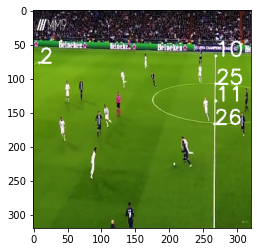

In [4]:
def plot_somepoints(x,y,i=5):
  font                   = cv2.FONT_HERSHEY_SIMPLEX
  fontScale              = 1
  fontColor              = (255,255,255)
  lineType               = 2
  xx=x[i].copy()/255.0
  yy=y[i]
  for p in range(29):
    x1= yy[p,0]
    y1= yy[p,1]
    if x1 < 0:
      continue
    cv2.circle(xx,(x1,y1),2,(1,1,1),-1)
    cv2.putText(xx,str(p), 
    (x1,y1), 
    font, 
    fontScale,
    fontColor,
    lineType)

  plt.imshow(xx)
plot_somepoints(x,y,120)

## convert the land marks coordinates in the x data (320,320,3)
## to y data (80,80,30)


In [5]:
#assuing x = y axis
shape1 = x.shape[1]
shape2 = 80
f = shape1/shape2
print(f)

4.0


In [6]:
# i will use one hot encoder in the next step
ye=np.zeros((x.shape[0],80,80,1),dtype=np.float32)

In [7]:
for xw in range(y.shape[0]):
  for yw in range(y.shape[1]):
    if y[xw,yw,0] !=-1:
      index=(yw+1)
      #(y[xw,yw,0]-1) -> to make land marks with zero indexing 
      xc=int(np.trunc((y[xw,yw,0]-1)/f))
      yc=int(np.trunc((y[xw,yw,1]-1)/f))
      ye[xw,yc,xc,0] =index

In [8]:
print(ye.shape)
print(ye.dtype)
print(x.shape)
print(x.dtype)

(565, 80, 80, 1)
float32
(565, 320, 320, 3)
uint8


In [9]:
yee=to_categorical(ye,num_classes=30)

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ye.reshape(-1)),
                                                 ye.reshape(-1))

In [11]:
class_weight_dict = dict(enumerate(class_weights))

In [14]:
xe=x.astype(np.float32)/255.0

In [41]:
input = tf.keras.layers.Input((320,320,3))
l = tf.keras.layers.Conv2D(128,(5,5),padding='same',strides=(2,2),activation='relu')(input)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(64,(5,5),padding='same',strides=(2,2),activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu')(l)
l=tf.keras.layers.BatchNormalization()(l)
l=tf.keras.layers.LeakyReLU()(l)
l = tf.keras.layers.Conv2D(30,(3,3),padding='same',activation='softmax')(l)

In [42]:
model=tf.keras.Model(input,l)

In [83]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)

In [113]:
def my_loss_fn(y_true, y_pred):
  yp=k.reshape(y_pred,(-1,30))
  yt=k.reshape(y_true,(-1,30))
  lose= tf.keras.losses.categorical_crossentropy(yt,yp).numpy()
  for h in range(lose.shape[0]):
    clas = np.argmax(yt[h])
    lose[h] = lose[h]*class_weight_dict[clas]
  lose=k.sum(tf.convert_to_tensor(lose))
  return lose

In [114]:
epochs =10
for e in range(epochs):
  for b in range(0,xe.shape[0],5):
    xb=xe[b:b+5]
    yb=yee[b:b+5]
    with tf.GradientTape() as tape:
      y_pred=model(xb,training=True)
      l=my_loss_fn(yb,y_pred)
    gf=tape.gradient(l,model.trainable_variables)
    opt1.apply_gradients(zip(gf,model.trainable_variables)) 

ValueError: ignored